<a href="https://colab.research.google.com/github/Elman295/Speech-Command-Classification/blob/main/Speech_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os

import torch
from torch import nn
import torch.nn.functional as F
import torchaudio
import IPython.display as idp
from torchaudio import datasets
from torchaudio import transforms
from torch.utils.data import Dataset, DataLoader

#`Data`

In [ ]:
class SubsetSC(datasets.SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("./", download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.normpath(os.path.join(self._path, line.strip())) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]


In [ ]:
train_data = SubsetSC("training")

test_data = SubsetSC("testing")

100%|██████████| 2.26G/2.26G [00:32<00:00, 74.5MB/s]


In [ ]:
wave, sr, label,sid, unum = train_data[10]

In [ ]:
print(wave.shape)

torch.Size([1, 16000])


In [ ]:
print(sr)

16000


In [ ]:
print(label)

backward


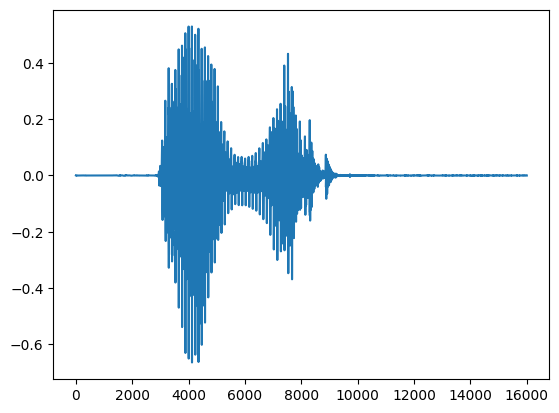

In [ ]:
plt.plot(wave.permute(1,0))
plt.show()

In [ ]:
train_data.get_metadata(10)

('speech_commands_v0.02/backward/02ade946_nohash_4.wav',
 16000,
 'backward',
 '02ade946',
 4)

In [ ]:
idp.Audio(wave, rate = sr)

In [ ]:
new_sample_rate = 8000

tfms = transforms.Resample(orig_freq=sr, new_freq=new_sample_rate)
wave = tfms(wave)
print(wave.shape)

torch.Size([1, 8000])


In [ ]:

wave = list(wave.view(8000).numpy())
print(wave)

[-2.82827e-05, -5.7792022e-05, -0.00017575343, -0.0001454043, -1.4675554e-05, -5.891839e-05, -3.1893492e-06, -4.514817e-05, 4.2190746e-05, -8.0747835e-05, -6.55043e-05, 2.8647688e-05, 3.198683e-05, 0.00011355504, 0.00020510302, 4.199802e-06, -1.4585522e-05, 4.5504174e-05, 8.379267e-05, 0.00015508843, 3.6818074e-05, -4.85314e-05, 2.2138422e-05, 7.206214e-05, 9.986545e-05, 0.00012103865, 9.8413926e-05, 6.113275e-05, 5.645038e-05, 5.7206216e-07, -8.503515e-05, -3.4781682e-05, -7.714737e-05, -0.00020693458, -0.00015120534, -1.4043477e-05, -0.0001248537, -0.00022831121, -0.000105255094, -0.00010566264, -0.0001129485, -0.00017051974, -7.020791e-05, -0.00012032243, -0.00020537995, -0.00014092232, -3.8245616e-05, -2.9488177e-05, -8.790126e-05, 4.8020585e-05, 6.236594e-05, 3.0334899e-05, -7.4571704e-05, -3.808533e-05, 1.7538514e-06, -6.590086e-05, -4.9449573e-05, -0.00014032624, -6.0344435e-05, -6.39416e-05, -0.0001639671, -0.000202487, -0.00015958838, -7.7965706e-05, -1.1772842e-05, 4.2627784e

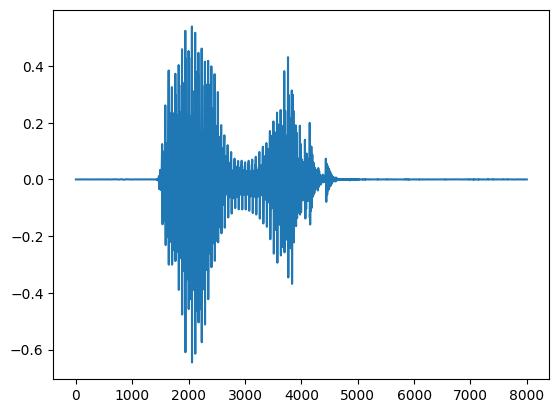

In [ ]:
plt.plot(wave)
plt.show()

In [ ]:
labels = ['backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow', 'forward', 'four', 'go', 'happy', 'house', 'learn', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'visual', 'wow', 'yes', 'zero']

In [ ]:
def label2index(word):
  return torch.tensor(labels.index(word))

In [ ]:
len(train_data)

84843

In [ ]:
class Data_Generator(Dataset):

  def __init__(self, data):
    self.data = data

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):

    wave, sr, label,sid, unum = self.data[idx]
    wave = tfms(wave)
    wave = list(wave.view(-1).numpy())
    while len(wave) <8000 :
      wave.append(0)

    wave = torch.tensor(wave).view(1,8000)

    label = label2index(label)

    return wave, label




In [ ]:
train_ds = Data_Generator(train_data)

test_ds = Data_Generator(test_data)

In [ ]:
train_dl = DataLoader(dataset = train_ds, batch_size = 32, shuffle = True)

test_dl = DataLoader(dataset = test_ds, batch_size = 32, shuffle = False)

In [ ]:
x,y = next(iter(train_dl))
print(x.shape)
print(y.shape)

torch.Size([32, 1, 8000])
torch.Size([32])


#`M5 architecture`

In [ ]:
class M5(nn.Module):

  def __init__(self):
    super(M5, self).__init__()

    self.conv1 = nn.Conv1d(1,16,80,16)
    self.bn_1 = nn.BatchNorm1d(16)
    self.pool_1 = nn.MaxPool1d(4)

    self.conv2 = nn.Conv1d(16,32,3,1)
    self.bn_2 = nn.BatchNorm1d(32)
    self.pool_2 = nn.MaxPool1d(4)

    self.conv3 = nn.Conv1d(32,64,3,1)
    self.bn_3 = nn.BatchNorm1d(64)
    self.pool_3 = nn.MaxPool1d(4)


    self.conv4 = nn.Conv1d(64,64,3,1)
    self.bn_4 = nn.BatchNorm1d(64)
    self.pool_4 = nn.MaxPool1d(4)

    self.mlp_head = nn.Linear(64, len(labels))






  def forward(self, x):

    f = self.pool_1(F.relu(self.bn_1(self.conv1(x))))
    f = self.pool_2(F.relu(self.bn_2(self.conv2(f))))
    f = self.pool_3(F.relu(self.bn_3(self.conv3(f))))
    f = self.pool_4(F.relu(self.bn_4(self.conv4(f))))
    f = f.view(-1,64)
    f = self.mlp_head(f)
    return f


In [ ]:
m5 = M5()
y = m5(x)
print(y.shape)

torch.Size([32, 35])


In [ ]:
m5

M5(
  (conv1): Conv1d(1, 16, kernel_size=(80,), stride=(16,))
  (bn_1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool_1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(16, 32, kernel_size=(3,), stride=(1,))
  (bn_2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool_2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn_3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool_3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn_4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool_4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (mlp_head): Linear(in_features=64, out_features=35, bias=

In [ ]:
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.Adam(params = m5.parameters(), lr = 1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=20, gamma=0.1)

In [ ]:
def train(data, model, opt, loss_fn):
  model.train()
  size = len(data.dataset)

  for b , (x,y) in enumerate(data):

    y_pred = model(x)
    loss = loss_fn(y_pred, y)
    opt.zero_grad()
    loss.backward()
    opt.step()

    if b % 100 == 0:
      print(f"loss:{loss.item()} [{b*len(x)} | {size}]")

In [ ]:
def test(data, model, loss_fn):

  model.eval()
  size = len(data.dataset)
  num_batch = len(data)
  test_loss, test_acc = 0,0

  with torch.no_grad():
    for x,y in data:
      y_pred = model(x)
      test_loss += loss_fn(y_pred, y).item()
      test_acc += (y_pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batch
    test_acc /= size

    print(f"test loss :{test_loss} accuracu:{test_acc * 100}")


In [ ]:
for e in range(5):
  print(f"epoch:{e+1}=-=-=-=")
  train(train_dl, m5, opt, loss_fn)
  test(test_dl, m5, loss_fn)
  scheduler.step()

epoch:1=-=-=-=
loss:3.6637773513793945 [0 | 84843]
loss:3.3996238708496094 [3200 | 84843]
loss:2.7511796951293945 [6400 | 84843]
loss:2.821138620376587 [9600 | 84843]
loss:2.391430616378784 [12800 | 84843]
loss:2.225036859512329 [16000 | 84843]
loss:2.188861846923828 [19200 | 84843]
loss:2.490039348602295 [22400 | 84843]
loss:2.219496965408325 [25600 | 84843]
loss:2.0512290000915527 [28800 | 84843]
loss:1.5422556400299072 [32000 | 84843]
loss:1.9180067777633667 [35200 | 84843]
loss:1.6306017637252808 [38400 | 84843]
loss:1.502272605895996 [41600 | 84843]
loss:1.3798891305923462 [44800 | 84843]
loss:1.2737181186676025 [48000 | 84843]
loss:1.1027371883392334 [51200 | 84843]
loss:1.4544084072113037 [54400 | 84843]
loss:1.4114216566085815 [57600 | 84843]
loss:0.9740461707115173 [60800 | 84843]
loss:1.3500977754592896 [64000 | 84843]
loss:1.4993195533752441 [67200 | 84843]
loss:1.5007076263427734 [70400 | 84843]
loss:1.3149833679199219 [73600 | 84843]
loss:1.4572699069976807 [76800 | 84843]